In [12]:
# Standard library imports
import csv
import itertools
import os
import os.path
import random
from glob import glob
from pathlib import Path
import zlib
import importlib

# Third-party imports
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import skimage
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.transform import resize
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     learning_curve, train_test_split)
from sklearn.utils import class_weight, shuffle
from tqdm import tqdm

# Keras-specific imports
import tensorflow as tf
import keras
from keras import backend as K
from keras import layers, models, optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (Activation, AveragePooling2D, BatchNormalization,
                          Conv2D, Dense, Dropout, Flatten, Lambda, MaxPool2D,
                          MaxPooling2D)
from keras.models import Model, Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.utils import to_categorical

# Custom imports
import fit
import evaluate
import viz

%matplotlib inline

In [47]:
X_test_pca = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_test_pca.npy")
y_test = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_test.npy")
y_testHot = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_testHot.npy")
X_test = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_test.npy")

In [94]:
model = tf.keras.models.load_model('assets/models/ASL_DNN_3D.h5')

In [95]:
# Predict the classes for the 3D test set
y_pred3D = model.predict(X_test)

# If the predictions are probabilities (as with some models), 
# you'll need to convert to predicted class labels by taking the argmax
if y_pred3D.ndim > 1:
    y_pred3D = np.argmax(y_pred3D, axis=1)

# Ensure 'y_test' is not one-hot encoded. If it is, convert it:
if y_test.ndim > 1:
    y_test3D = np.argmax(y_test, axis=1)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred3D)

print(f"Accuracy score: {accuracy}")


544/544 ━━━━━━━━━━━━━━━━━━━━ 160s 293ms/step
Accuracy score: 0.9358045977011494


In [ ]:

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred3D)

print(f"Accuracy score: {accuracy}")


In [48]:
model1 = tf.keras.models.load_model('assets/models/ASL_DNN_1D.h5')

In [49]:
from sklearn.metrics import accuracy_score

# Predict the classes for the 1D test set
y_pred1DHot = model1.predict(X_test_pca)

# If the predictions are probabilities (as with some models), 
# you'll need to convert to predicted class labels by taking the argmax
if y_pred1DHot.ndim > 1:
    y_pred1D = np.argmax(y_pred1DHot, axis=1)

# Ensure 'y_test' is not one-hot encoded. If it is, convert it:
if y_testHot.ndim > 1:
    y_test1D = np.argmax(y_testHot, axis=1)

# Calculate the accuracy score
accuracy = accuracy_score(y_test1D, y_pred1D)

print(f"Accuracy score: {accuracy}")


544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
Accuracy score: 0.8170114942528736


In [42]:
import matplotlib.pyplot as plt

def plot_sample_images(X, y, labels):
    # Find the index of the first occurrence of each class in labels
    unique_labels = set(y)
    indices = {label: next(i for i, label_id in enumerate(y) if label_id == label) for label in unique_labels}
    
    # Prepare the subplot
    fig, axes = plt.subplots(3, 10, figsize=(15, 9))
    axes = axes.flatten()
    
    # Set the background of the figure to be transparent
    fig.patch.set_facecolor('none')
    fig.patch.set_alpha(0)
    
    # Plot an image for each class
    for i, label in enumerate(sorted(indices.keys())):
        idx = indices[label]
        ax = axes[i]
        ax.imshow(X[idx], interpolation='nearest')
        
        # Set title with white font color
        ax.set_title(labels[label], color='white', fontsize=20)
        
        ax.axis('off')
    
    # Hide any unused subplots
    for ax in axes[len(indices):]:
        ax.axis('off')
    
    plt.tight_layout()
    
    # Make the figure background transparent when saving as well
    plt.show()


In [44]:
X_train_pca = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_train_pca.npy")
y_train = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_train.npy")
y_trainHot = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_trainHot.npy")
X_train = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_train.npy")

In [45]:
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "delete", "nothing", "space"]


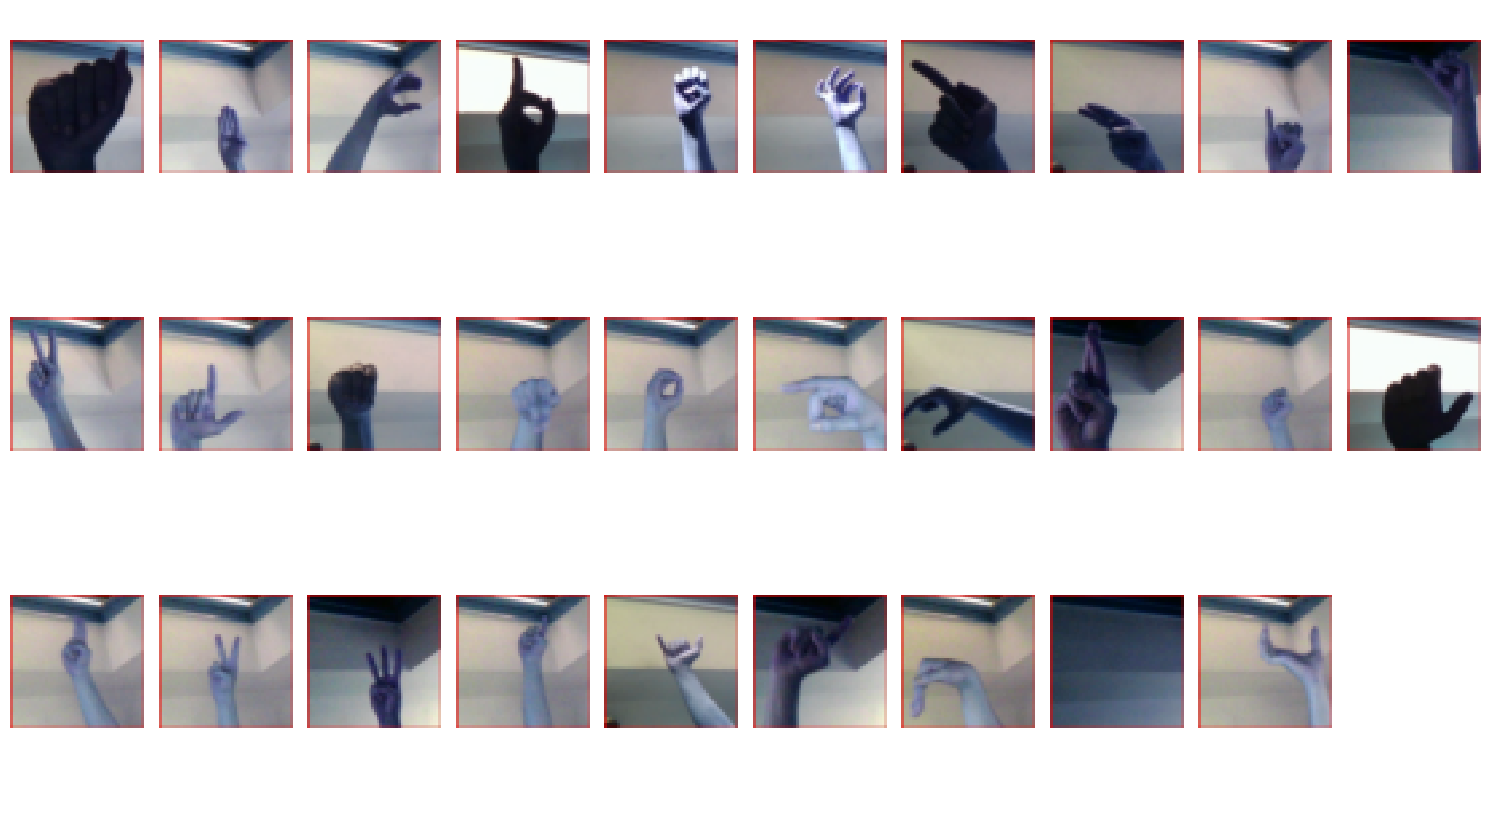

In [46]:
plot_sample_images(X_train, y_train, labels)

In [89]:
from PIL import ImageFont
from math import ceil
from visualkeras.utils import *
from visualkeras.layer_utils import *


def layered_view(model, to_file: str = None, min_z: int = 20, min_xy: int = 20, max_z: int = 400,
                 max_xy: int = 2000,
                 scale_z: float = 0.1, scale_xy: float = 4, type_ignore: list = None, index_ignore: list = None,
                 color_map: dict = None, one_dim_orientation: str = 'z',
                 background_fill: Any = 'white', draw_volume: bool = True, padding: int = 10,
                 spacing: int = 10, draw_funnel: bool = True, shade_step=10, legend: bool = False,
                 font: ImageFont = None, font_color: Any = 'black') -> Image:
    """
    Generates a architecture visualization for a given linear keras model (i.e. one input and output tensor for each
    layer) in layered style (great for CNN).

    :param model: A keras model that will be visualized.
    :param to_file: Path to the file to write the created image to. If the image does not exist yet it will be created, else overwritten. Image type is inferred from the file ending. Providing None will disable writing.
    :param min_z: Minimum z size in pixel a layer will have.
    :param min_xy: Minimum x and y size in pixel a layer will have.
    :param max_z: Maximum z size in pixel a layer will have.
    :param max_xy: Maximum x and y size in pixel a layer will have.
    :param scale_z: Scalar multiplier for the z size of each layer.
    :param scale_xy: Scalar multiplier for the x and y size of each layer.
    :param type_ignore: List of layer types in the keras model to ignore during drawing.
    :param index_ignore: List of layer indexes in the keras model to ignore during drawing.
    :param color_map: Dict defining fill and outline for each layer by class type. Will fallback to default values for not specified classes.
    :param one_dim_orientation: Axis on which one dimensional layers should be drawn. Can  be 'x', 'y' or 'z'.
    :param background_fill: Color for the image background. Can be str or (R,G,B,A).
    :param draw_volume: Flag to switch between 3D volumetric view and 2D box view.
    :param padding: Distance in pixel before the first and after the last layer.
    :param spacing: Spacing in pixel between two layers
    :param draw_funnel: If set to True, a funnel will be drawn between consecutive layers
    :param shade_step: Deviation in lightness for drawing shades (only in volumetric view)
    :param legend: Add a legend of the layers to the image
    :param font: Font that will be used for the legend. Leaving this set to None, will use the default font.
    :param font_color: Color for the font if used. Can be str or (R,G,B,A).

    :return: Generated architecture image.
    """

    # Iterate over the model to compute bounds and generate boxes

    boxes = list()
    layer_y = list()
    color_wheel = ColorWheel()
    current_z = padding
    x_off = -1

    layer_types = list()

    img_height = 0
    max_right = 0

    if type_ignore is None:
        type_ignore = list()

    if index_ignore is None:
        index_ignore = list()

    if color_map is None:
        color_map = dict()

    for index, layer in enumerate(model.layers):

        # Ignore layers that the use has opted out to
        if type(layer) in type_ignore or index in index_ignore:
            continue

        # Do no render the SpacingDummyLayer, just increase the pointer
        if type(layer) == SpacingDummyLayer:
            current_z += layer.spacing
            continue

        layer_type = type(layer)

        if layer_type not in layer_types:
            layer_types.append(layer_type)

        x = min_xy
        y = min_xy
        z = min_z

        if hasattr(layer, 'output'):
            shape = layer.output.shape
        elif hasattr(layer, 'output_shape'):
            shape = layer.output_shape if isinstance(layer.output_shape, tuple) else layer.output_shape[0]
        else:
            raise AttributeError(f"'{type(layer).__name__}' object has no attribute 'output' or 'output_shape'")


        if len(shape) >= 4:
            x = min(max(shape[1] * scale_xy, x), max_xy)
            y = min(max(shape[2] * scale_xy, y), max_xy)
            z = min(max(self_multiply(shape[3:]) * scale_z, z), max_z)
        elif len(shape) == 3:
            x = min(max(shape[1] * scale_xy, x), max_xy)
            y = min(max(shape[2] * scale_xy, y), max_xy)
            z = min(max(z), max_z)
        elif len(shape) == 2:
            if one_dim_orientation == 'x':
                x = min(max(shape[1] * scale_xy, x), max_xy)
            elif one_dim_orientation == 'y':
                y = min(max(shape[1] * scale_xy, y), max_xy)
            elif one_dim_orientation == 'z':
                z = min(max(shape[1] * scale_z, z), max_z)
            else:
                raise ValueError(f"unsupported orientation {one_dim_orientation}")
        else:
            raise RuntimeError(f"not supported tensor shape {layer.output_shape}")

        box = Box()

        box.de = 0
        if draw_volume:
            box.de = x / 3

        if x_off == -1:
            x_off = box.de / 2

        # top left coordinate
        box.x1 = current_z - box.de / 2
        box.y1 = box.de

        # bottom right coordinate
        box.x2 = box.x1 + z
        box.y2 = box.y1 + y

        box.fill = color_map.get(layer_type, {}).get('fill', color_wheel.get_color(layer_type))
        box.outline = color_map.get(layer_type, {}).get('outline', 'black')
        color_map[layer_type] = {'fill': box.fill, 'outline': box.outline}

        box.shade = shade_step
        boxes.append(box)
        layer_y.append(box.y2 - (box.y1 - box.de))

        # Update image bounds
        hh = box.y2 - (box.y1 - box.de)
        if hh > img_height:
            img_height = hh

        if box.x2 + box.de > max_right:
            max_right = box.x2 + box.de

        current_z += z + spacing

    # Generate image
    img_width = max_right + x_off + padding
    img = Image.new('RGBA', (int(ceil(img_width)), int(ceil(img_height))), background_fill)
    draw = aggdraw.Draw(img)

    # x, y correction (centering)
    for i, node in enumerate(boxes):
        y_off = (img.height - layer_y[i]) / 2
        node.y1 += y_off
        node.y2 += y_off

        node.x1 += x_off
        node.x2 += x_off

    # Draw created boxes

    last_box = None

    for box in boxes:

        pen = aggdraw.Pen(get_rgba_tuple(box.outline))

        if last_box is not None and draw_funnel:
            draw.line([last_box.x2 + last_box.de, last_box.y1 - last_box.de,
                       box.x1 + box.de, box.y1 - box.de], pen)

            draw.line([last_box.x2 + last_box.de, last_box.y2 - last_box.de,
                       box.x1 + box.de, box.y2 - box.de], pen)

            draw.line([last_box.x2, last_box.y2,
                       box.x1, box.y2], pen)

            draw.line([last_box.x2, last_box.y1,
                       box.x1, box.y1], pen)

        box.draw(draw)

        last_box = box

    draw.flush()

    # Create layer color legend
    if legend:
        if font is None:
            font = ImageFont.load_default()

        text_height = font.getsize("Ag")[1]
        cube_size = text_height

        de = 0
        if draw_volume:
            de = cube_size // 2

        patches = list()

        for layer_type in layer_types:
            label = layer_type.__name__
            text_size = font.getsize(label)
            label_patch_size = (cube_size + de + spacing + text_size[0], cube_size + de)
            # this only works if cube_size is bigger than text height

            img_box = Image.new('RGBA', label_patch_size, background_fill)
            img_text = Image.new('RGBA', label_patch_size, (0, 0, 0, 0))
            draw_box = aggdraw.Draw(img_box)
            draw_text = ImageDraw.Draw(img_text)

            box = Box()
            box.x1 = 0
            box.x2 = box.x1 + cube_size
            box.y1 = de
            box.y2 = box.y1 + cube_size
            box.de = de
            box.shade = shade_step
            box.fill = color_map.get(layer_type, {}).get('fill', "#000000")
            box.outline = color_map.get(layer_type, {}).get('outline', "#000000")
            box.draw(draw_box)

            text_x = box.x2 + box.de + spacing
            text_y = (label_patch_size[1] - text_height) / 2  # 2D center; use text_height and not the current label!
            draw_text.text((text_x, text_y), label, font=font, fill=font_color)

            draw_box.flush()
            img_box.paste(img_text, mask=img_text)
            patches.append(img_box)

        legend_image = linear_layout(patches, max_width=img.width, max_height=img.height, padding=padding, spacing=spacing,
                                     background_fill=background_fill, horizontal=True)
        img = vertical_image_concat(img, legend_image, background_fill=background_fill)

    if to_file is not None:
        img.save(to_file)

    return img


In [90]:
from keras.layers import InputLayer
from PIL import ImageFont

font = ImageFont.truetype("assets/Montserrat-ExtraBold.ttf", 16)

/var/folders/p_/2j3j3pp93175gydc37vsk5nh0000gn/T/ipykernel_89534/2869398779.py:194: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_height = font.getsize("Ag")[1]
/var/folders/p_/2j3j3pp93175gydc37vsk5nh0000gn/T/ipykernel_89534/2869398779.py:205: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_size = font.getsize(label)


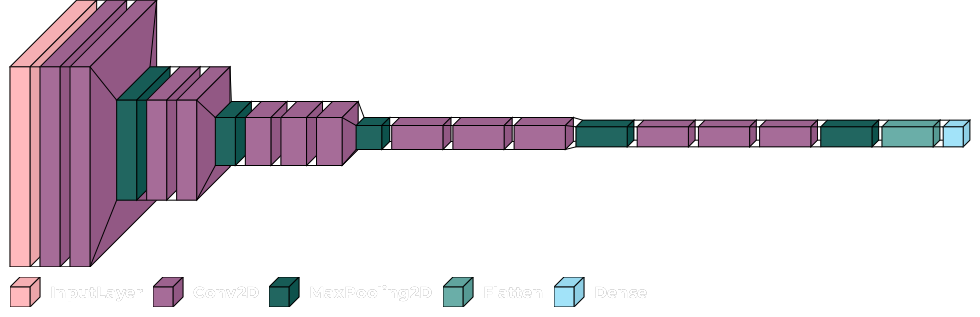

In [91]:

layered_view(model, legend=True, background_fill= (0, 0, 0,0), font_color="white",font=font, color_map = {
    InputLayer: {'fill': (255, 185, 189), 'outline': 'black'},
    Dense: {'fill': (162, 227, 249) , 'outline': 'black'},
    Flatten: {'fill': (106, 174, 168) , 'outline': 'black'}, 
    Conv2D: {'fill': (166, 108, 152), 'outline': 'black'},
    MaxPooling2D: {'fill': (33, 102, 96), 'outline': 'black'}
})

In [92]:
# Accessing layer attributes
for layer in model.layers:
    # Check if the layer has the attribute 'output_shape'
    if hasattr(layer, 'output_shape'):
        print(layer.output_shape)
    else:
        # Use alternative approach
        print(layer.output.shape)

(None, 50, 50, 3)
(None, 50, 50, 64)
(None, 50, 50, 64)
(None, 25, 25, 64)
(None, 25, 25, 128)
(None, 25, 25, 128)
(None, 12, 12, 128)
(None, 12, 12, 256)
(None, 12, 12, 256)
(None, 12, 12, 256)
(None, 6, 6, 256)
(None, 6, 6, 512)
(None, 6, 6, 512)
(None, 6, 6, 512)
(None, 3, 3, 512)
(None, 3, 3, 512)
(None, 3, 3, 512)
(None, 3, 3, 512)
(None, 1, 1, 512)
(None, 512)
(None, 30)


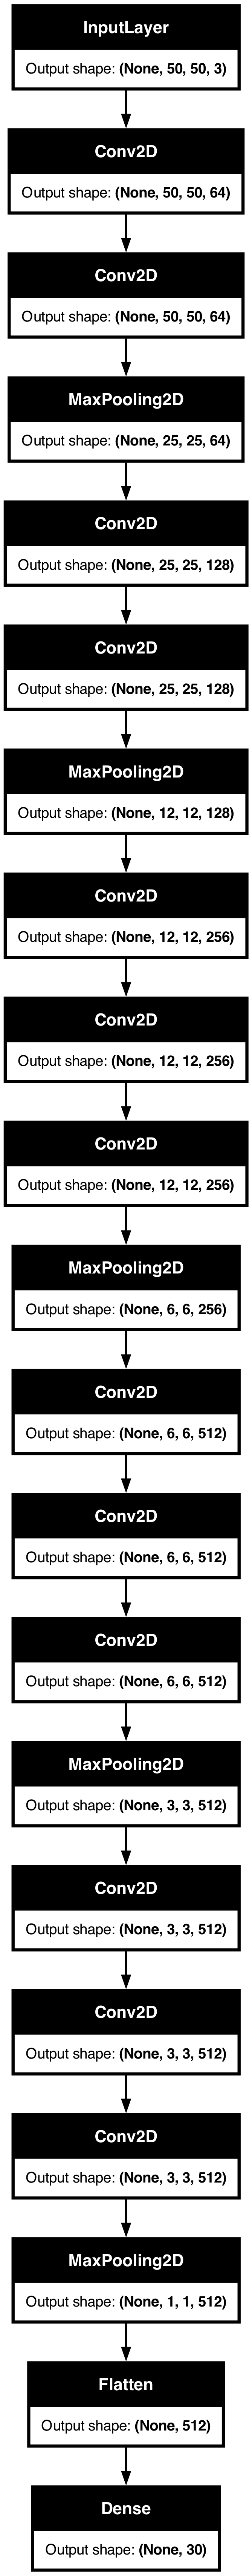

In [93]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)